In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [2]:
# Activation functions
def sigmoid(Z):
  return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(A):
  return A * (1 - A)

def relu(x):
  return np.maximum(0,x)

def relu_derivative(x):
  return (x > 0).astype(float)

def tanh(x):
  return np.tanh(x)

def tanh_derivative(x):
  return 1 - np.tanh(x)**2

def softmax(Z):
  expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # to prevent overflow
  return expZ / np.sum(expZ, axis=0, keepdims=True)

In [4]:
# Initialize parameters
def initialize_parameters(layer_sizes, initialization="he"):
  parameters = {}
  num_of_layers = len(layer_sizes)

  for i in range(1, num_of_layers):
    if initialization == "he":
      parameters[f'W{i}'] = np.random.randn(layer_sizes[i], layer_sizes[i-1]) * np.sqrt(2 / layer_sizes[i-1])
    elif initialization == "xavier":
      parameters[f'W{i}'] = np.random.randn(layer_sizes[i], layer_sizes[i-1]) * np.sqrt(1 / layer_sizes[i-1])
    elif initialization == "random":
      parameters[f'W{i}'] = np.random.randn(layer_sizes[i], layer_sizes[i-1]) * 0.01
    parameters[f'b{i}'] = np.zeros((layer_sizes[i], 1))
    parameters[f'gamma{i}'] = np.ones((layer_sizes[i], 1))  # Scale parameter for batch norm
    parameters[f'beta{i}'] = np.zeros((layer_sizes[i], 1))  # Shift parameter for batch norm

  return parameters

# Forward Propogation
def forward_propagation(X, parameters, activations, is_training=True, batch_norm_cache=None):
  A = X
  caches = []
  num_layers = len(activations)
  if batch_norm_cache is None:
    batch_norm_cache = {}

  for i in range(1, num_layers + 1):
    W = parameters[f'W{i}']
    b = parameters[f'b{i}']
    Z = np.dot(W,A) + b

    # Batch normalization
    if is_training:
      mu = np.mean(Z, axis=1, keepdims=True)
      var = np.var(Z, axis=1, keepdims=True)
      Z_norm = (Z - mu) / np.sqrt(var + 1e-8)
      Z_tilde = parameters[f'gamma{i}'] * Z_norm + parameters[f'beta{i}']
      batch_norm_cache[f'mu{i}'] = mu
      batch_norm_cache[f'var{i}'] = var
      batch_norm_cache[f'Z_norm{i}'] = Z_norm
    else:

      Z_norm = (Z - batch_norm_cache[f'mu{i}']) / np.sqrt(batch_norm_cache[f'var{i}'] + 1e-8)
      Z_tilde = parameters[f'gamma{i}'] * Z_norm + parameters[f'beta{i}']


    if(activations[i-1] == "sigmoid"):
      A = sigmoid(Z_tilde)
    elif(activations[i-1] == "relu"):
      A = relu(Z_tilde)
    elif(activations[i-1] == "tanh"):
      A = tanh(Z_tilde)
    elif(activations[i-1] == "softmax"):
      A = softmax(Z_tilde)

    caches.append({"Z":Z, "A":A, "W":W, "b": b, "Z_norm":Z_norm, "gamma":parameters[f'gamma{i}'], "beta": parameters[f'beta{i}']})

  return A, caches, batch_norm_cache

# Loss compute
def compute_loss(y,A):
  m = y.shape[1]
  loss = -np.sum(y*np.log(A+1e-8))/m
  return loss


# Back propogation
def back_propagation(X, y, caches, activations, batch_norm_cache):
  grads = {}
  gradient_magnitudes = {}
  m = X.shape[1]
  num_layers = len(caches)

  # Computing gradients for the output layer
  A_last = caches[-1]["A"]
  dA = A_last - y

  for i in reversed(range(num_layers)):
    Z, A, W, b, Z_norm, gamma, beta = caches[i]["Z"], caches[i]["A"], caches[i]["W"], caches[i]["b"], caches[i]["Z_norm"], caches[i]["gamma"], caches[i]["beta"]

    if(activations[i] == "sigmoid"):
      dZ_tilde = dA * sigmoid_derivative(A)
    elif(activations[i] == "relu"):
      dZ_tilde = dA * relu_derivative(A)
    elif(activations[i] == "tanh"):
      dZ_tilde = dA * tanh_derivative(A)
    elif(activations[i] == "softmax"):
      dZ_tilde = dA

    # Gradients for batch normalization
    dZ_norm = dZ_tilde * gamma
    dvar = np.sum(dZ_norm * (Z - batch_norm_cache[f'mu{i+1}']) * (-0.5) * (batch_norm_cache[f'var{i+1}'] + 1e-8)**(-1.5), axis=1, keepdims=True)
    dmu = np.sum(dZ_norm * (-1 / np.sqrt(batch_norm_cache[f'var{i+1}'] + 1e-8)), axis=1, keepdims=True) + dvar * np.mean(-2 * (Z - batch_norm_cache[f'mu{i+1}']), axis=1, keepdims=True)
    dZ = dZ_norm / np.sqrt(batch_norm_cache[f'var{i+1}'] + 1e-8) + dvar * 2 * (Z - batch_norm_cache[f'mu{i+1}']) / m + dmu / m

    dW = np.dot(dZ, caches[i-1]["A"].T) / m if i > 0 else np.dot(dZ, X.T)/m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dgamma = np.sum(dZ_tilde * Z_norm, axis=1, keepdims=True) / m
    dbeta = np.sum(dZ_tilde, axis=1, keepdims=True) / m

    grads[f'dW{i+1}'] = dW
    grads[f'db{i+1}'] = db
    grads[f'dgamma{i+1}'] = dgamma
    grads[f'dbeta{i+1}'] = dbeta


    # Compute gradient magnitude for the current layer
    gradient_magnitudes[f'layer{i+1}'] = np.linalg.norm(dW)  # Use Frobenius norm for dW
    dA = np.dot(W.T, dZ) if i > 0 else None

  return grads, gradient_magnitudes

# Update parameters
def update_parameters(parameters, grads, learning_rate):
  num_layers = len(parameters) // 4

  for i in range(1,num_layers + 1):

    # print(f"Layer {i}: W{i} shape {parameters[f'W{i}'].shape}, dW{i} shape {grads[f'dW{i}'].shape}")  # Debugging
    # print(f"Layer {i}: b{i} shape {parameters[f'b{i}'].shape}, db{i} shape {grads[f'db{i}'].shape}")  # Debugging

    #grads[f'dW{i}'] = grads[f'dW{i}'].T
    parameters[f'W{i}'] -= learning_rate * grads[f'dW{i}']
    parameters[f'b{i}'] -= learning_rate * grads[f'db{i}']
    parameters[f'gamma{i}'] -= learning_rate * grads[f'dgamma{i}']
    parameters[f'beta{i}'] -= learning_rate * grads[f'dbeta{i}']

  return parameters

# Compute accuracy
def compute_accuracy(y_true, A_pred):
  y_pred = np.argmax(A_pred, axis=0)
  y_true_labels = np.argmax(y_true, axis=0)
  accuracy = np.mean(y_pred == y_true_labels)*100  # Accuracy in percentage
  return accuracy

# Train Neural Network
def train_neural_network(X_train, y_train, layer_sizes, activations, num_epochs=100, learning_rate=0.01, initialization="random"):
  loss_history = []
  accuracy_history = []
  parameters = initialize_parameters(layer_sizes, initialization)
  batch_norm_cache = {}
  gradient_magnitudes_history = {f'layer{i+1}': [] for i in range(len(layer_sizes) - 1)}  # To store gradient magnitudes for each layer
  for epoch in range(num_epochs):
    # Forward propogation
    A, caches, batch_norm_cache = forward_propagation(X_train, parameters, activations, is_training=True)

    # Compute loss
    loss = compute_loss(y_train, A)
    loss_history.append(loss)

    # Compute accuracy
    accuracy = compute_accuracy(y_train, A)
    accuracy_history.append(accuracy)

    # Backward propagation
    grads, gradient_magnitudes = back_propagation(X_train, y_train, caches, activations, batch_norm_cache)

    # Update parameters
    parameters = update_parameters(parameters, grads, learning_rate)

    # Print loss and accuracy every 10 epochs
    if(epoch % 10 == 0):
      print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Store gradient magnitudes for each layer
    for layer in gradient_magnitudes:
      gradient_magnitudes_history[layer].append(gradient_magnitudes[layer])

  # Plot loss and accuracy curves
  plt.figure(figsize=(12,5))

  # Loss curve
  plt.subplot(1, 2, 1)
  plt.plot(range(num_epochs), loss_history, label="Loss", color="red")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss Curve")
  plt.legend()

  # Accuracy Curve
  plt.subplot(1, 2, 2)
  plt.plot(range(num_epochs), accuracy_history, label="Accuracy", color="blue")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy (%)")
  plt.title("Accuracy Curve")
  plt.legend()

  plt.show()

  return parameters, loss_history, batch_norm_cache, gradient_magnitudes_history

# Evaluation of model
def evaluate_model(X_test, y_test, parameters, activations, batch_norm_cache):
  # Convert batch_norm_cache keys to strings if they are not already
  batch_norm_cache = {str(k): v for k, v in batch_norm_cache.items()}

  # Forward propogation on the test data
  A, _, _ = forward_propagation(X_test, parameters, activations, is_training=False, batch_norm_cache=batch_norm_cache)

  # Compute accuracy
  accuracy = compute_accuracy(y_test, A)
  print(f"Test Accuracy: {accuracy:.2f}%")
  return accuracy,A

In [5]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and flatten
X_train = X_train.reshape(X_train.shape[0], -1)/255.0
X_test = X_test.reshape(X_test.shape[0], -1)/255.0

# One-hot encoding for labels
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

X_train = X_train.T
y_train = y_train.T
X_test = X_test.T
y_test = y_test.T

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
def plot_gradient_magnitudes(gradient_magnitudes_history):
    plt.figure(figsize=(12, 6))
    for layer, magnitudes in gradient_magnitudes_history.items():
        plt.plot(magnitudes, label=f'Layer {layer}')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient Magnitude')
    plt.title('Gradient Magnitudes for Different Layers')
    plt.legend()
    plt.show()

In [7]:
def train_and_evaluate_network(X_train, y_train, X_test, y_test, layer_sizes, activations, num_epochs=100, learning_rate=0.01, initialization="random"):
    parameters, loss_history, batch_norm_cache, gradient_magnitudes_history = train_neural_network(X_train, y_train, layer_sizes, activations, num_epochs, learning_rate, initialization)
    accuracy, A = evaluate_model(X_test, y_test, parameters, activations, batch_norm_cache)

    # Iterate through the caches list
    # Plot activation histograms
    print("\nPlotting activation histograms for hidden layers:")
    _, caches,_ = forward_propagation(X_train, parameters, activations, is_training=False, batch_norm_cache=batch_norm_cache)  # Get latest activations
    for layer_idx, cache in enumerate(caches):
        # Extract the activation (A) from the cache dictionary
        if isinstance(cache, dict):  # Check if cache is a dictionary
            if "A" in cache:  # Check if "A" is the key for activations
                A = cache["A"]
            else:
                # If the key is different, inspect the cache to find the correct key
                print(f"Cache for layer {layer_idx + 1} does not contain key 'A'. Available keys: {cache.keys()}")
                continue
        else:
            print(f"Cache for layer {layer_idx + 1} is not a dictionary. Type: {type(cache)}")
            continue

        # Flatten the activation to plot the histogram
        A_flat = A.flatten()

        # Plot the histogram
        plt.figure()
        plt.hist(A_flat, bins=50, color='blue', alpha=0.7)
        plt.title(f'Activation Histogram for Layer {layer_idx + 1}')
        plt.xlabel('Activation Value')
        plt.ylabel('Frequency')
        plt.show()


    return loss_history, accuracy, gradient_magnitudes_history

In [8]:
# Define network configurations for 3, 5, 7, and 10 layers
network_configs = [
    # 6layer network
    ([784, 256, 128, 64, 32, 10], ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"]),
]

Training Sigmoid network with 5 layers using Xavier initialization
Epoch 0, Loss: 2.8195, Accuracy: 9.33%
Epoch 10, Loss: 1.5429, Accuracy: 52.12%
Epoch 20, Loss: 1.2665, Accuracy: 68.30%
Epoch 30, Loss: 1.1504, Accuracy: 73.88%
Epoch 40, Loss: 1.0770, Accuracy: 76.96%
Epoch 50, Loss: 1.0232, Accuracy: 79.02%
Epoch 60, Loss: 0.9810, Accuracy: 80.49%
Epoch 70, Loss: 0.9465, Accuracy: 81.68%
Epoch 80, Loss: 0.9175, Accuracy: 82.56%
Epoch 90, Loss: 0.8926, Accuracy: 83.24%


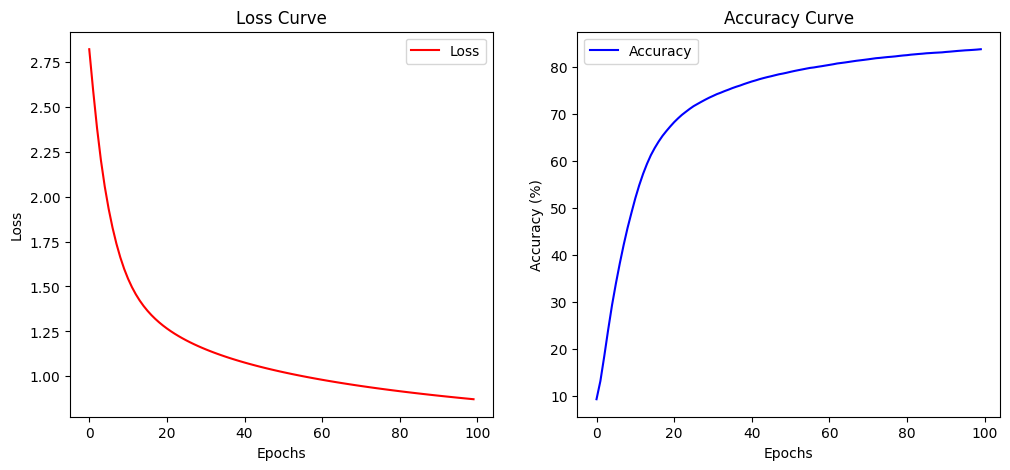

Test Accuracy: 85.11%

Plotting activation histograms for hidden layers:


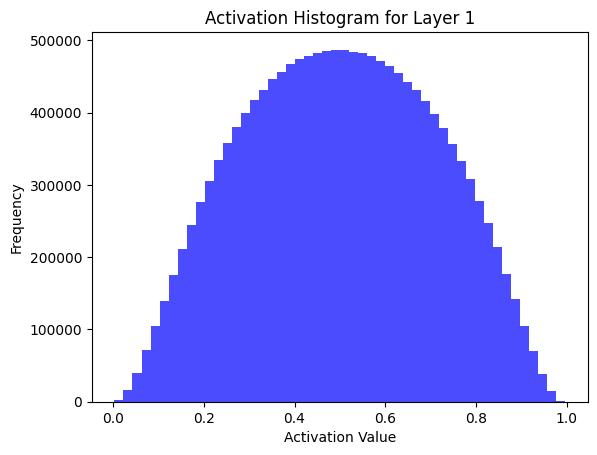

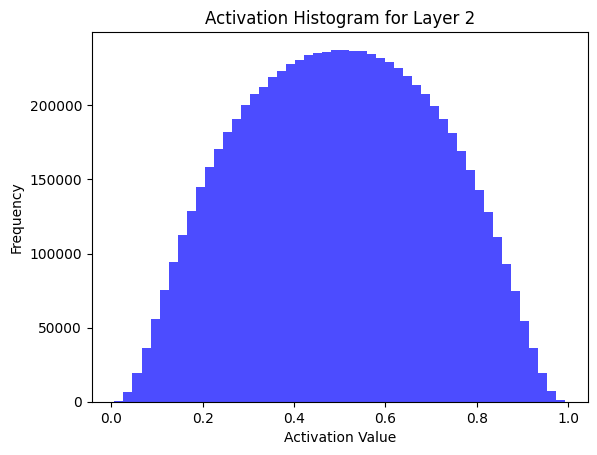

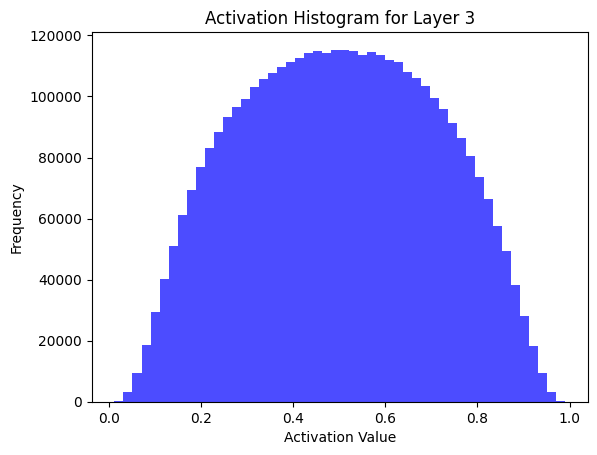

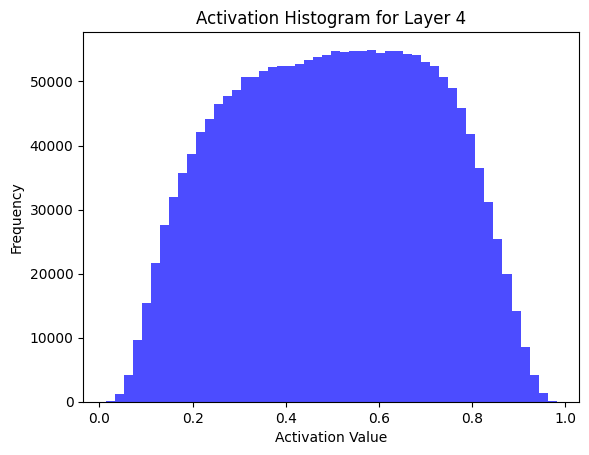

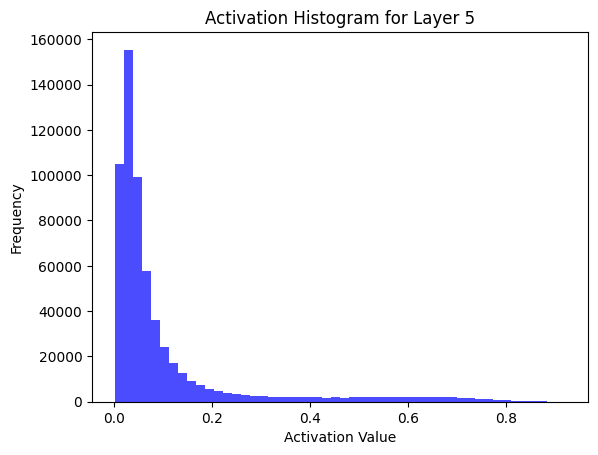

In [9]:
# Train and evaluate each network configuration
loss_histories = []
accuracies = []
gradient_magnitudes_histories = []

for layer_sizes, activations in network_configs:
    print(f"Training Sigmoid network with {len(layer_sizes) - 1} layers using Xavier initialization")
    loss_history, accuracy, gradient_magnitudes_history = train_and_evaluate_network(X_train, y_train, X_test, y_test, layer_sizes, activations, num_epochs=100, learning_rate=0.01, initialization="xavier")
    loss_histories.append(loss_history)
    accuracies.append(accuracy)
    gradient_magnitudes_histories.append(gradient_magnitudes_history)

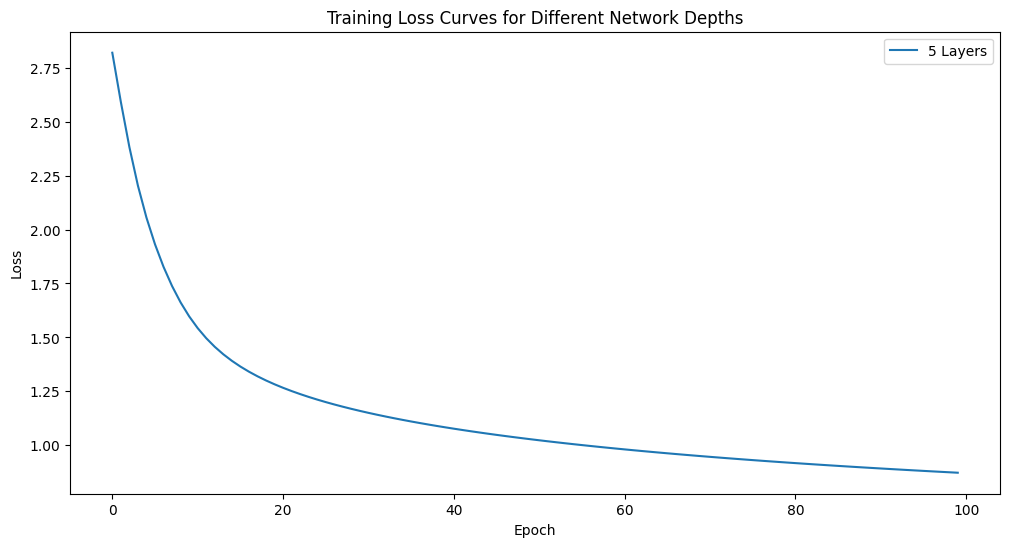

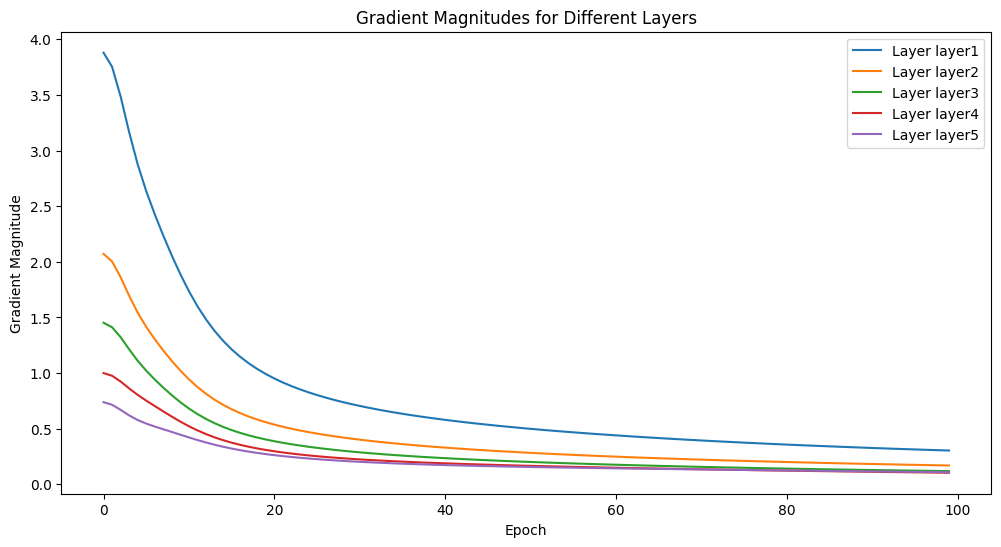

In [11]:
# Plot training loss curves for networks of different depths
plt.figure(figsize=(12, 6))
for i, loss_history in enumerate(loss_histories):
    plt.plot(loss_history, label=f'{len(network_configs[i][0]) - 1} Layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves for Different Network Depths')
plt.legend()
plt.show()


# Plot gradient magnitudes for different layers
plot_gradient_magnitudes(gradient_magnitudes_histories[0])

Training Sigmoid network with 5 layers using He initialization
Epoch 0, Loss: 2.7921, Accuracy: 7.00%
Epoch 10, Loss: 1.8611, Accuracy: 35.63%
Epoch 20, Loss: 1.5248, Accuracy: 54.16%
Epoch 30, Loss: 1.3639, Accuracy: 63.15%
Epoch 40, Loss: 1.2647, Accuracy: 68.14%
Epoch 50, Loss: 1.1948, Accuracy: 71.61%
Epoch 60, Loss: 1.1414, Accuracy: 74.09%
Epoch 70, Loss: 1.0983, Accuracy: 75.82%
Epoch 80, Loss: 1.0624, Accuracy: 77.24%
Epoch 90, Loss: 1.0314, Accuracy: 78.44%


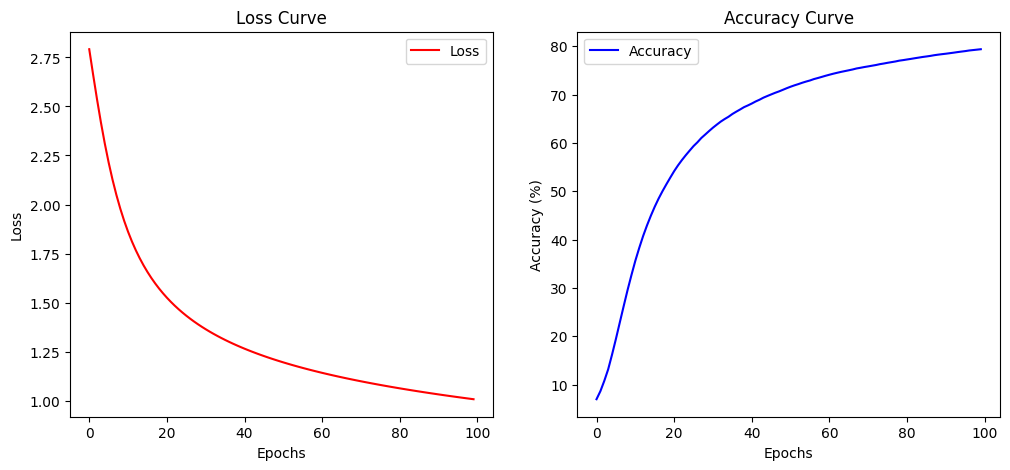

Test Accuracy: 79.96%

Plotting activation histograms for hidden layers:


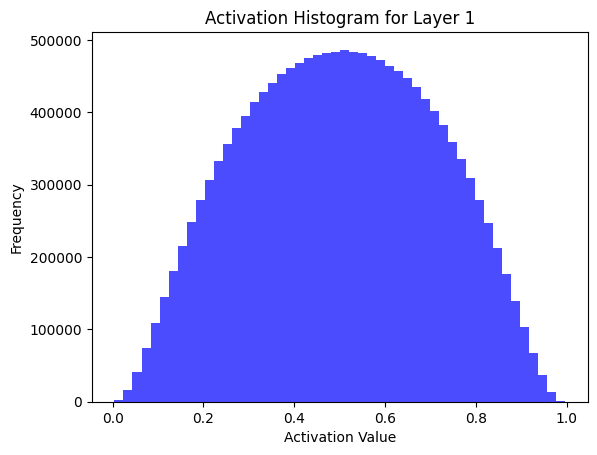

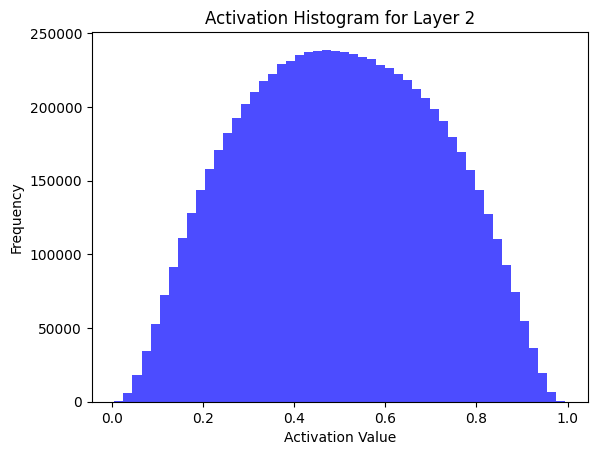

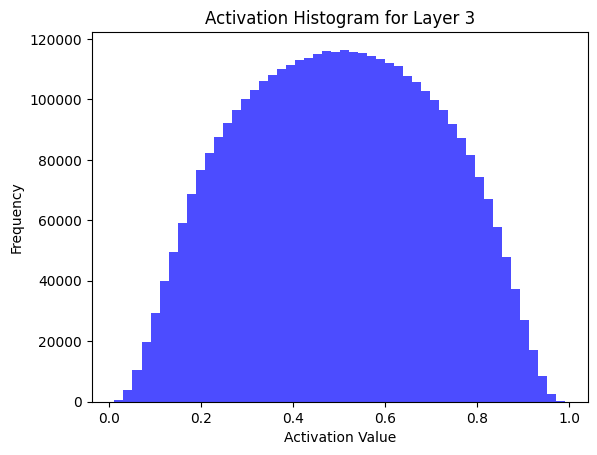

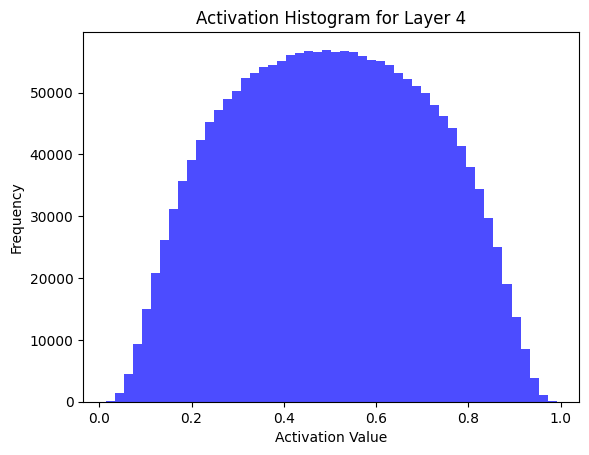

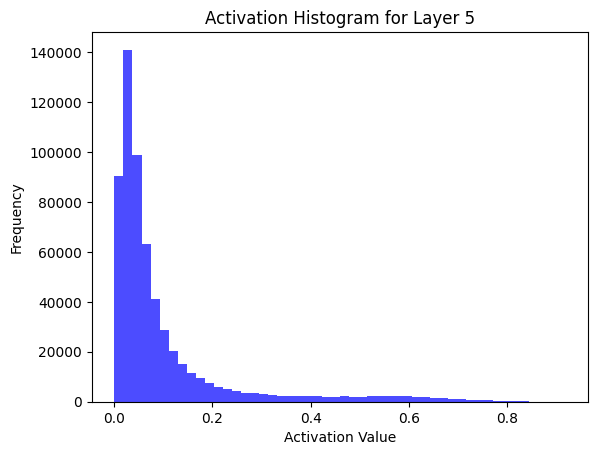

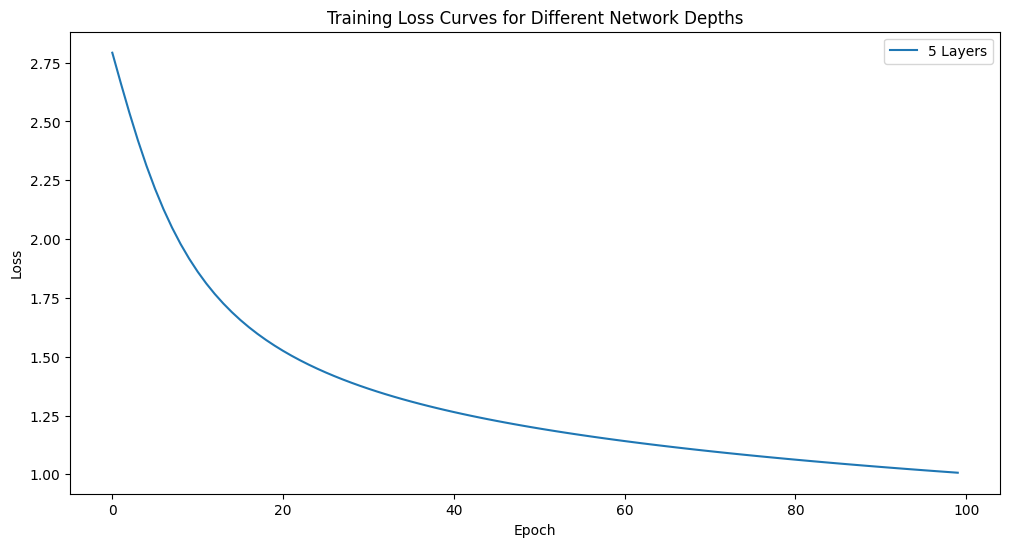

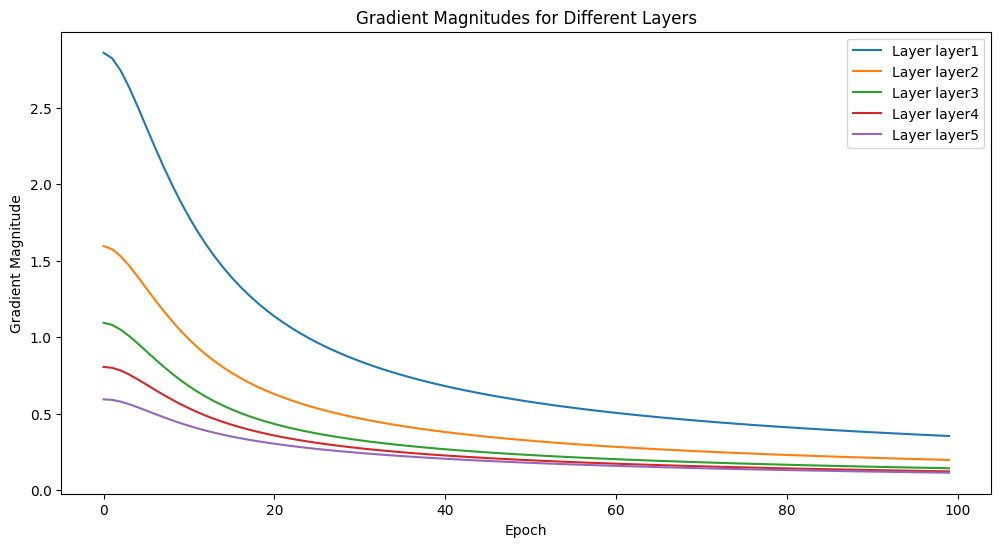

In [12]:
# Define network configurations for 3, 5, 7, and 10 layers
network_configs = [
    # 6layer network
    ([784, 256, 128, 64, 32, 10], ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"]),
]

# Train and evaluate each network configuration
loss_histories = []
accuracies = []
gradient_magnitudes_histories = []

for layer_sizes, activations in network_configs:
    print(f"Training Sigmoid network with {len(layer_sizes) - 1} layers using He initialization")
    loss_history, accuracy, gradient_magnitudes_history = train_and_evaluate_network(X_train, y_train, X_test, y_test, layer_sizes, activations, num_epochs=100, learning_rate=0.01, initialization="he")
    loss_histories.append(loss_history)
    accuracies.append(accuracy)
    gradient_magnitudes_histories.append(gradient_magnitudes_history)

# Plot training loss curves for networks of different depths
plt.figure(figsize=(12, 6))
for i, loss_history in enumerate(loss_histories):
    plt.plot(loss_history, label=f'{len(network_configs[i][0]) - 1} Layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves for Different Network Depths')
plt.legend()
plt.show()


# Plot gradient magnitudes for different layers
plot_gradient_magnitudes(gradient_magnitudes_histories[0])



Training ReLU network with 5 layers using Xavier initialization
Epoch 0, Loss: 2.5954, Accuracy: 12.61%
Epoch 10, Loss: 1.7786, Accuracy: 41.07%
Epoch 20, Loss: 1.4830, Accuracy: 55.09%
Epoch 30, Loss: 1.3231, Accuracy: 63.57%
Epoch 40, Loss: 1.2164, Accuracy: 69.14%
Epoch 50, Loss: 1.1369, Accuracy: 73.25%
Epoch 60, Loss: 1.0735, Accuracy: 76.30%
Epoch 70, Loss: 1.0207, Accuracy: 78.49%
Epoch 80, Loss: 0.9754, Accuracy: 80.17%
Epoch 90, Loss: 0.9358, Accuracy: 81.43%


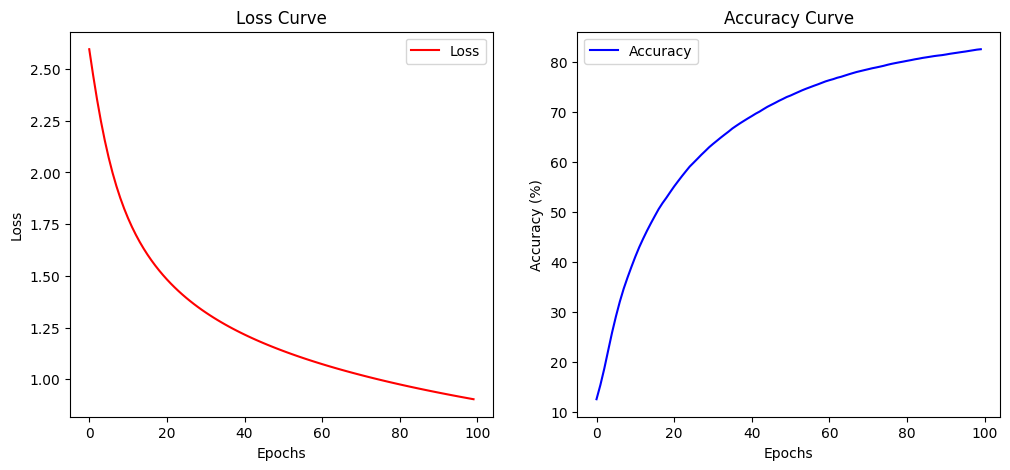

Test Accuracy: 82.37%

Plotting activation histograms for hidden layers:


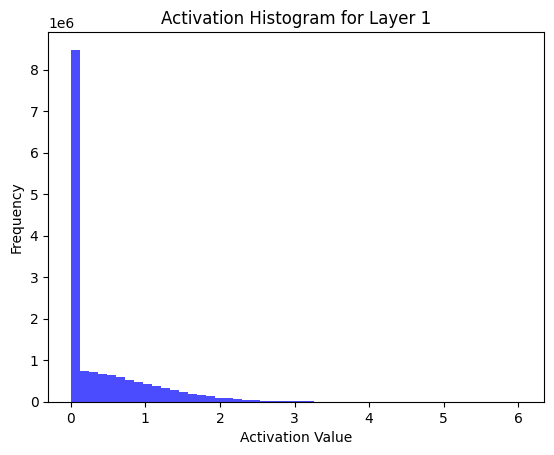

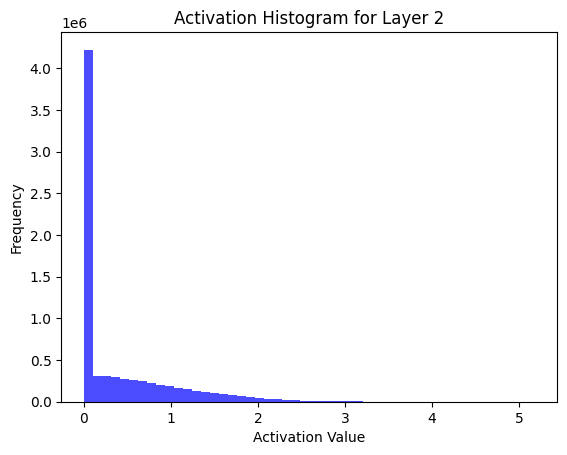

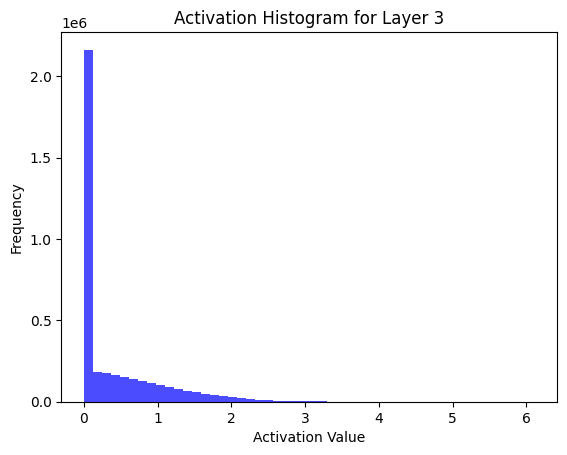

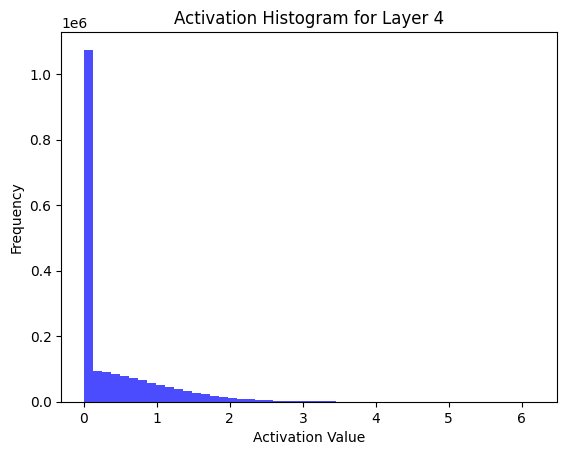

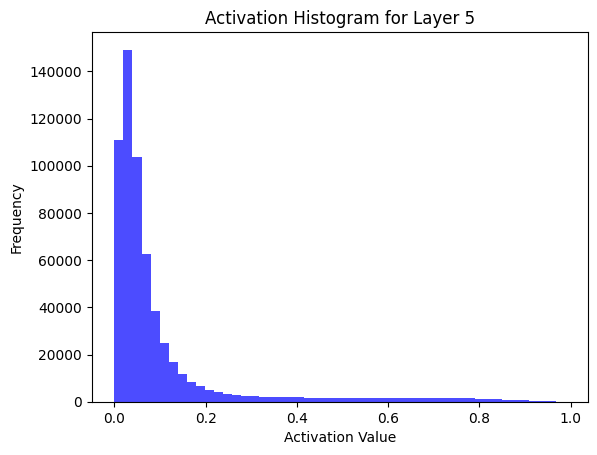

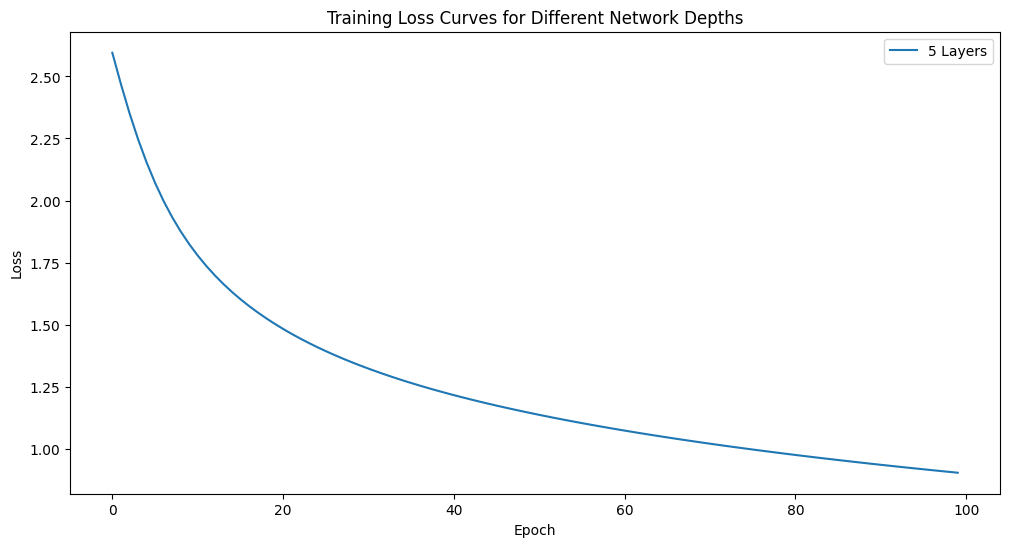

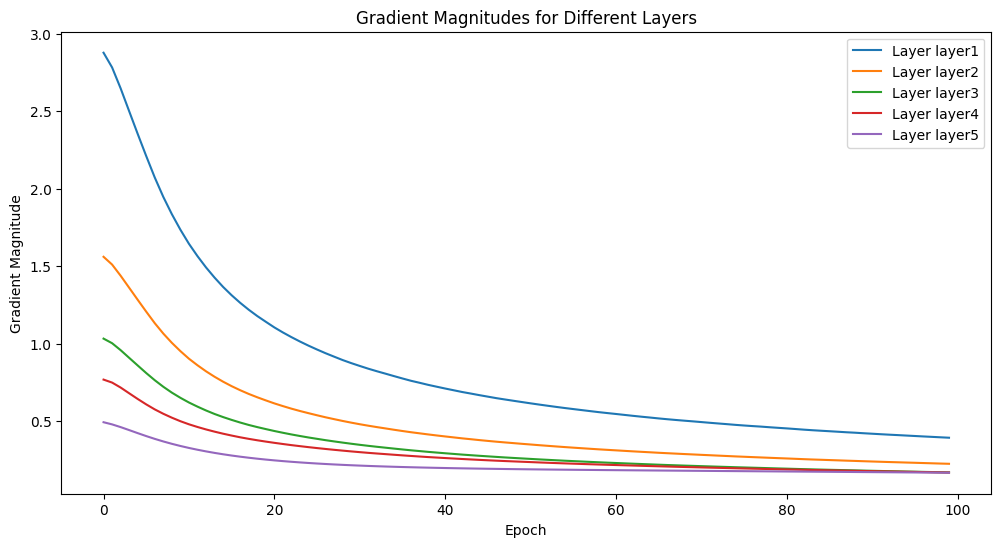

In [13]:
# Define network configurations for 3, 5, 7, and 10 layers
network_configs = [
    # 6layer network
    ([784, 256, 128, 64, 32, 10], ["relu", "relu", "relu", "relu", "softmax"]),
]

# Train and evaluate each network configuration
loss_histories = []
accuracies = []
gradient_magnitudes_histories = []

for layer_sizes, activations in network_configs:
    print(f"Training ReLU network with {len(layer_sizes) - 1} layers using Xavier initialization")
    loss_history, accuracy, gradient_magnitudes_history = train_and_evaluate_network(X_train, y_train, X_test, y_test, layer_sizes, activations, num_epochs=100, learning_rate=0.01, initialization="xavier")
    loss_histories.append(loss_history)
    accuracies.append(accuracy)
    gradient_magnitudes_histories.append(gradient_magnitudes_history)

# Plot training loss curves for networks of different depths
plt.figure(figsize=(12, 6))
for i, loss_history in enumerate(loss_histories):
    plt.plot(loss_history, label=f'{len(network_configs[i][0]) - 1} Layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves for Different Network Depths')
plt.legend()
plt.show()


# Plot gradient magnitudes for different layers
plot_gradient_magnitudes(gradient_magnitudes_histories[0])



Training ReLU network with 5 layers using He initialization
Epoch 0, Loss: 2.6172, Accuracy: 11.29%
Epoch 10, Loss: 2.1140, Accuracy: 25.56%
Epoch 20, Loss: 1.8206, Accuracy: 38.42%
Epoch 30, Loss: 1.6366, Accuracy: 47.67%
Epoch 40, Loss: 1.5073, Accuracy: 54.60%
Epoch 50, Loss: 1.4096, Accuracy: 59.77%
Epoch 60, Loss: 1.3321, Accuracy: 63.68%
Epoch 70, Loss: 1.2683, Accuracy: 66.83%
Epoch 80, Loss: 1.2141, Accuracy: 69.45%
Epoch 90, Loss: 1.1668, Accuracy: 71.55%


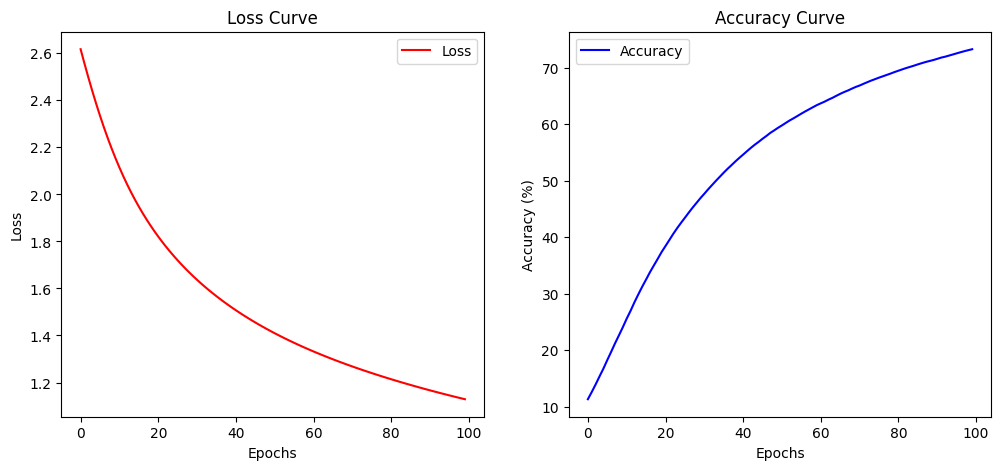

Test Accuracy: 73.42%

Plotting activation histograms for hidden layers:


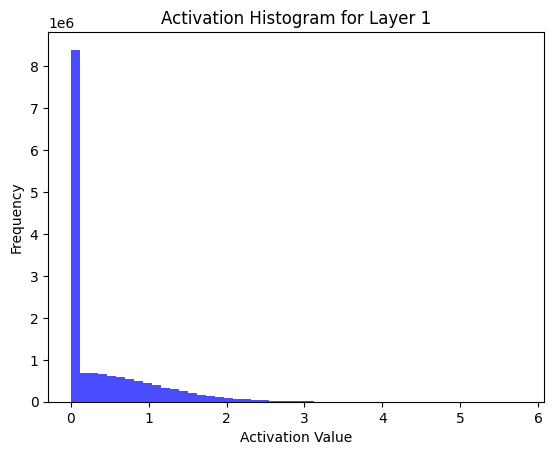

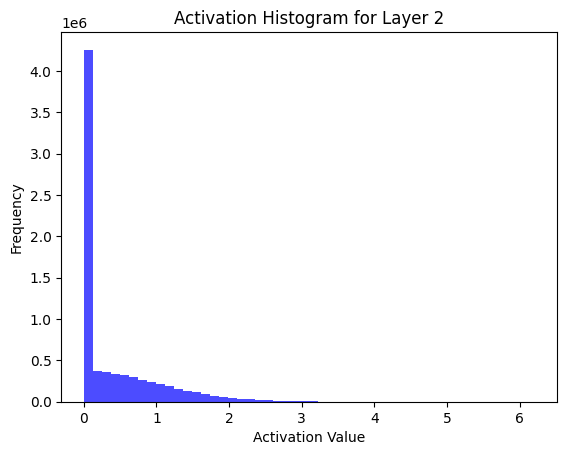

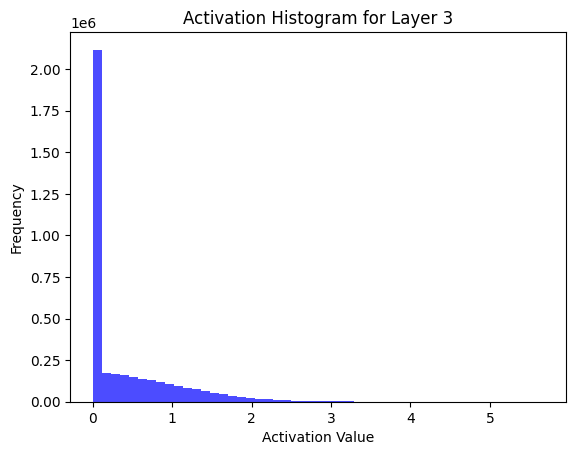

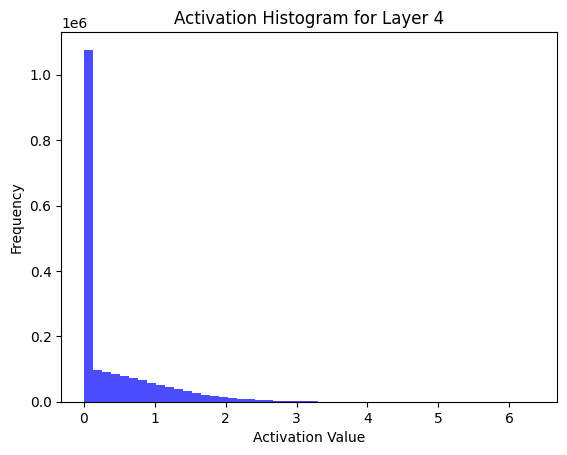

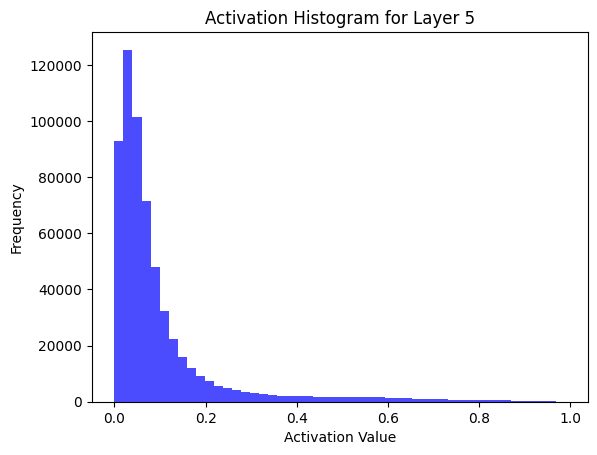

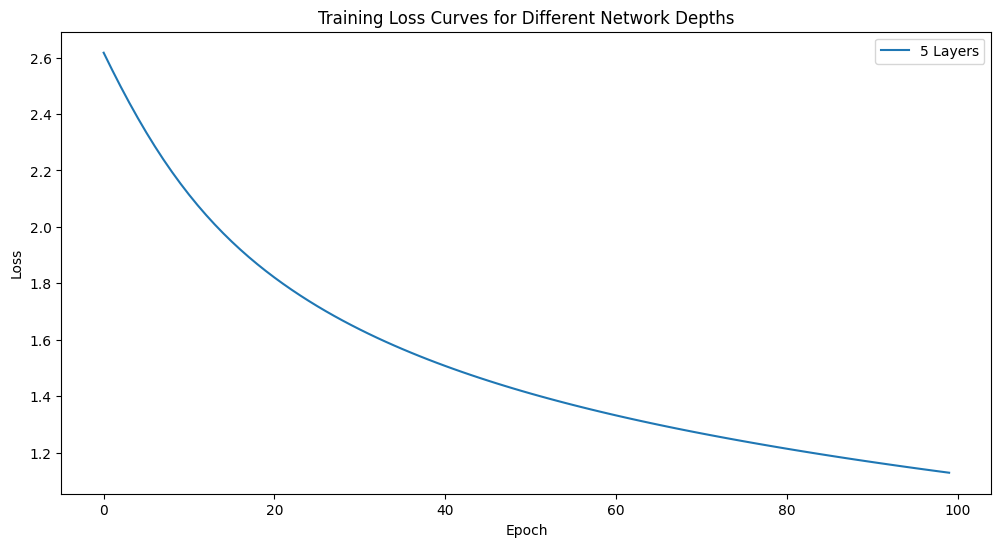

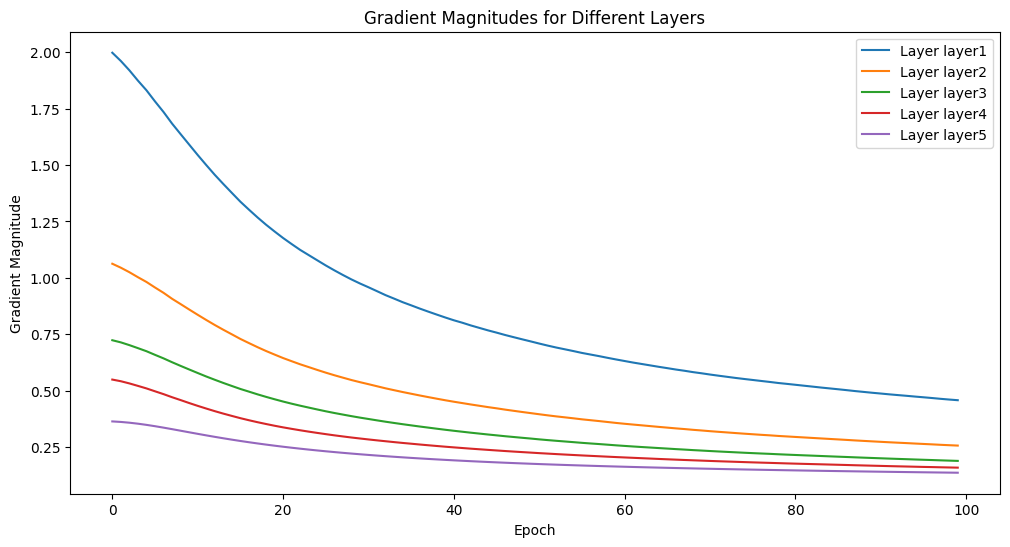

In [14]:
# Define network configurations for 3, 5, 7, and 10 layers
network_configs = [
    # 6layer network
    ([784, 256, 128, 64, 32, 10], ["relu", "relu", "relu", "relu", "softmax"]),
]

# Train and evaluate each network configuration
loss_histories = []
accuracies = []
gradient_magnitudes_histories = []

for layer_sizes, activations in network_configs:
    print(f"Training ReLU network with {len(layer_sizes) - 1} layers using He initialization")
    loss_history, accuracy, gradient_magnitudes_history = train_and_evaluate_network(X_train, y_train, X_test, y_test, layer_sizes, activations, num_epochs=100, learning_rate=0.01, initialization="he")
    loss_histories.append(loss_history)
    accuracies.append(accuracy)
    gradient_magnitudes_histories.append(gradient_magnitudes_history)

# Plot training loss curves for networks of different depths
plt.figure(figsize=(12, 6))
for i, loss_history in enumerate(loss_histories):
    plt.plot(loss_history, label=f'{len(network_configs[i][0]) - 1} Layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves for Different Network Depths')
plt.legend()
plt.show()


# Plot gradient magnitudes for different layers
plot_gradient_magnitudes(gradient_magnitudes_histories[0])



Training Tanh network with 5 layers using Xavier initialization
Epoch 0, Loss: 2.7876, Accuracy: 8.59%
Epoch 10, Loss: 1.4098, Accuracy: 59.42%
Epoch 20, Loss: 1.1801, Accuracy: 70.85%
Epoch 30, Loss: 1.0723, Accuracy: 75.61%
Epoch 40, Loss: 1.0041, Accuracy: 78.53%
Epoch 50, Loss: 0.9546, Accuracy: 80.36%
Epoch 60, Loss: 0.9157, Accuracy: 81.69%
Epoch 70, Loss: 0.8837, Accuracy: 82.71%
Epoch 80, Loss: 0.8564, Accuracy: 83.56%
Epoch 90, Loss: 0.8326, Accuracy: 84.28%


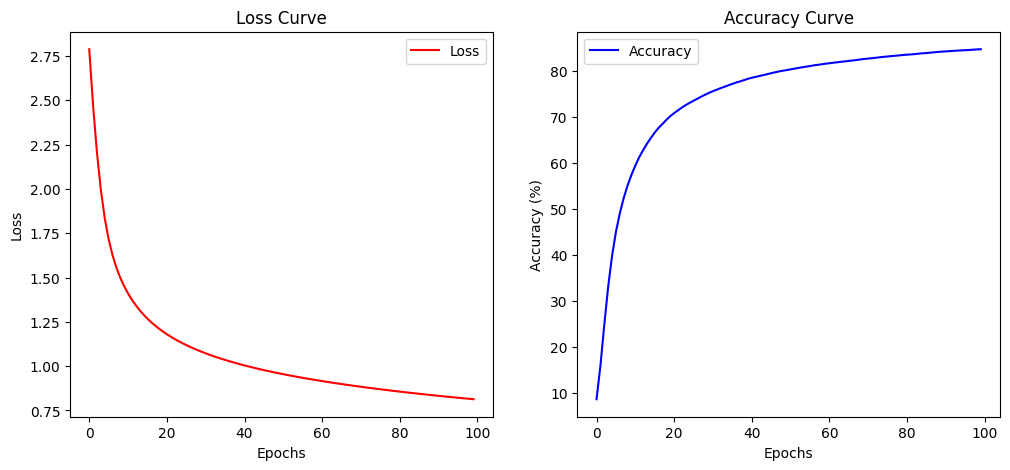

Test Accuracy: 85.72%

Plotting activation histograms for hidden layers:


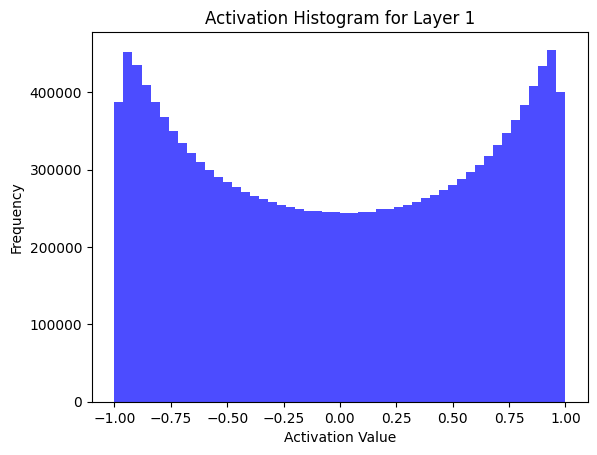

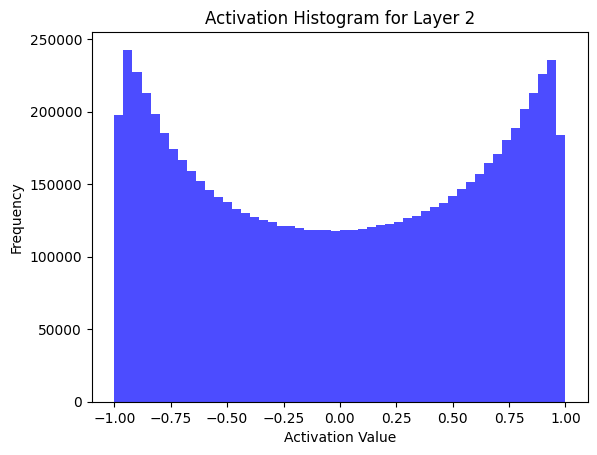

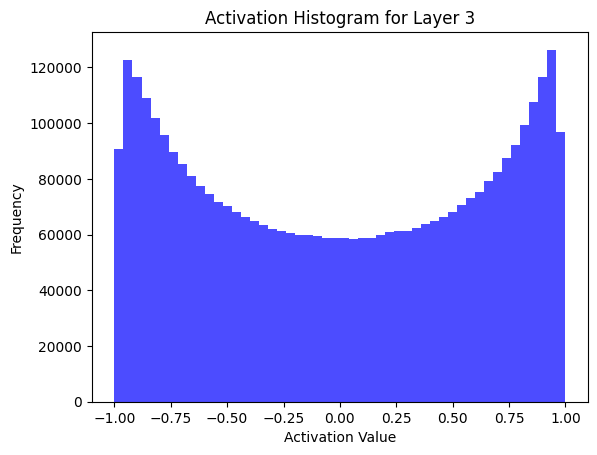

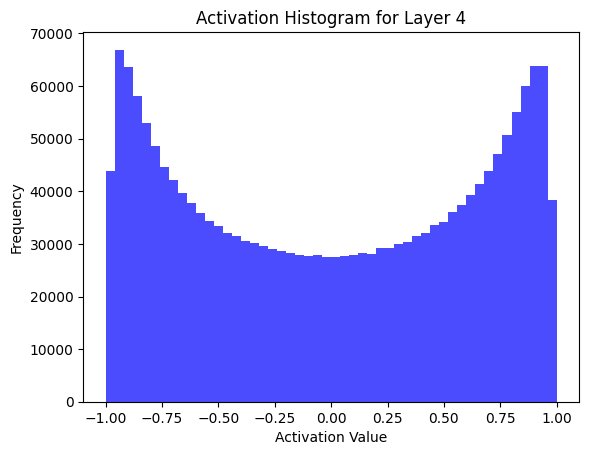

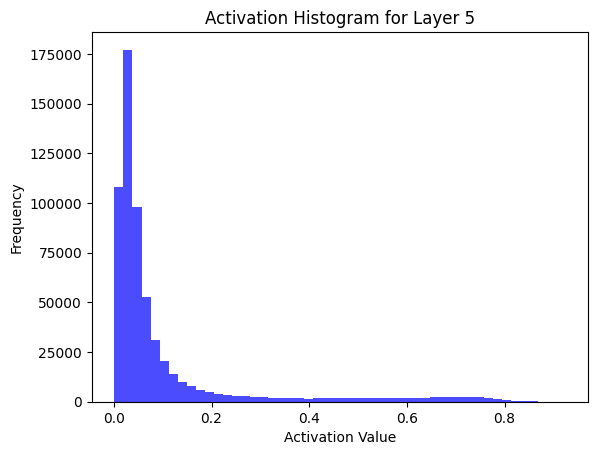

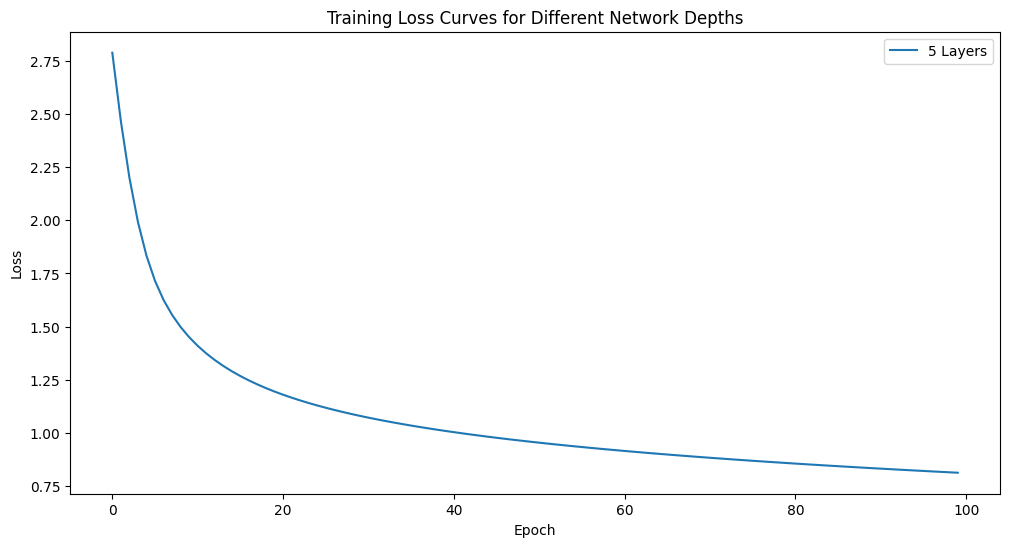

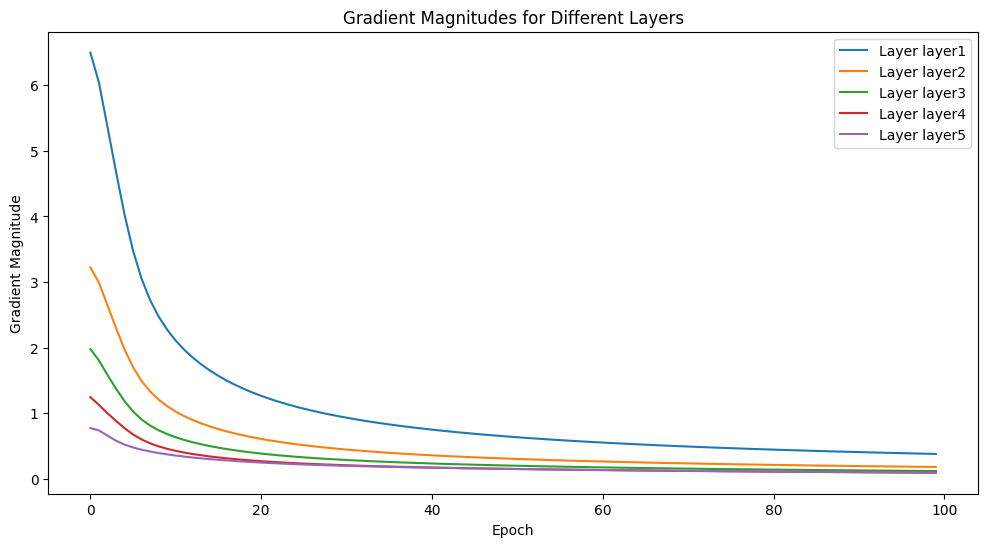

In [15]:
# Define network configurations for 3, 5, 7, and 10 layers
network_configs = [
    # 6layer network
    ([784, 256, 128, 64, 32, 10], ["tanh", "tanh", "tanh", "tanh", "softmax"]),
]

# Train and evaluate each network configuration
loss_histories = []
accuracies = []
gradient_magnitudes_histories = []

for layer_sizes, activations in network_configs:
    print(f"Training Tanh network with {len(layer_sizes) - 1} layers using Xavier initialization")
    loss_history, accuracy, gradient_magnitudes_history = train_and_evaluate_network(X_train, y_train, X_test, y_test, layer_sizes, activations, num_epochs=100, learning_rate=0.01, initialization="xavier")
    loss_histories.append(loss_history)
    accuracies.append(accuracy)
    gradient_magnitudes_histories.append(gradient_magnitudes_history)

# Plot training loss curves for networks of different depths
plt.figure(figsize=(12, 6))
for i, loss_history in enumerate(loss_histories):
    plt.plot(loss_history, label=f'{len(network_configs[i][0]) - 1} Layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves for Different Network Depths')
plt.legend()
plt.show()


# Plot gradient magnitudes for different layers
plot_gradient_magnitudes(gradient_magnitudes_histories[0])



Training Tanh network with 5 layers using He initialization
Epoch 0, Loss: 2.8277, Accuracy: 7.79%
Epoch 10, Loss: 1.6169, Accuracy: 50.09%
Epoch 20, Loss: 1.3083, Accuracy: 65.79%
Epoch 30, Loss: 1.1831, Accuracy: 71.56%
Epoch 40, Loss: 1.1096, Accuracy: 74.81%
Epoch 50, Loss: 1.0580, Accuracy: 76.93%
Epoch 60, Loss: 1.0182, Accuracy: 78.44%
Epoch 70, Loss: 0.9856, Accuracy: 79.63%
Epoch 80, Loss: 0.9580, Accuracy: 80.61%
Epoch 90, Loss: 0.9339, Accuracy: 81.37%


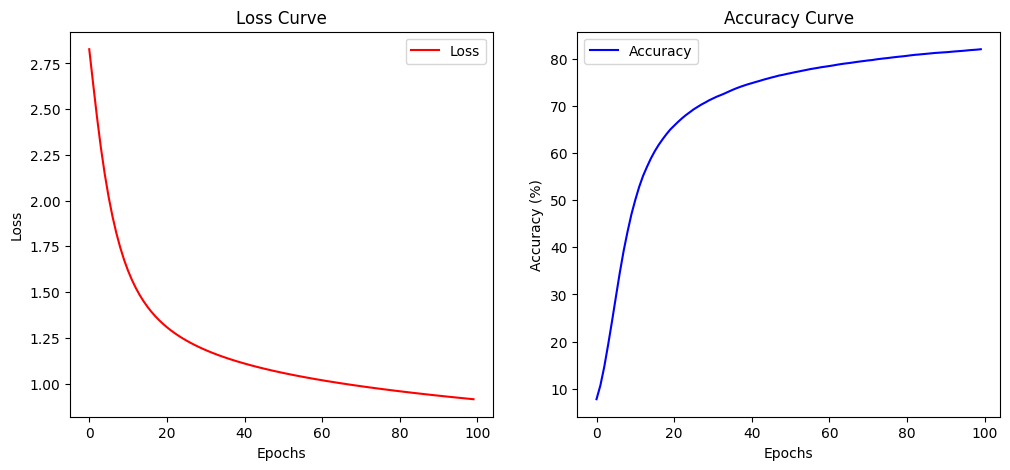

Test Accuracy: 83.14%

Plotting activation histograms for hidden layers:


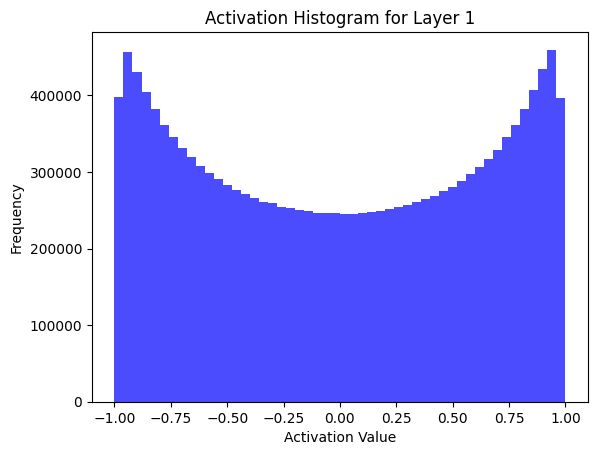

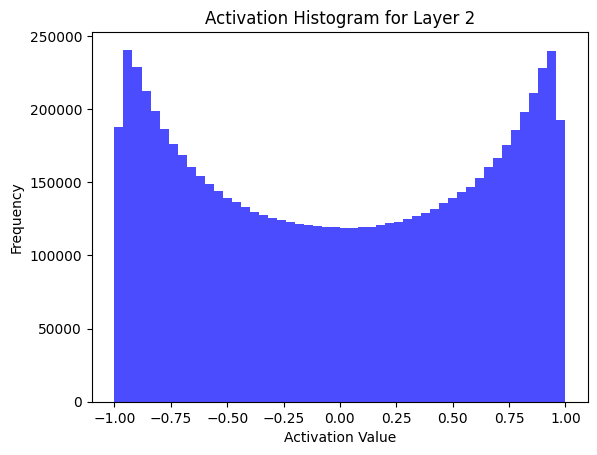

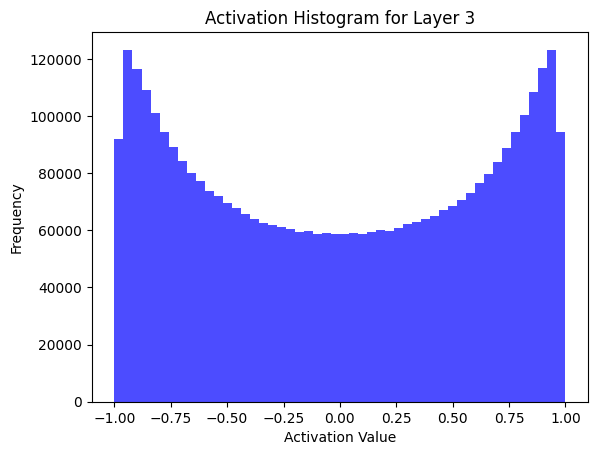

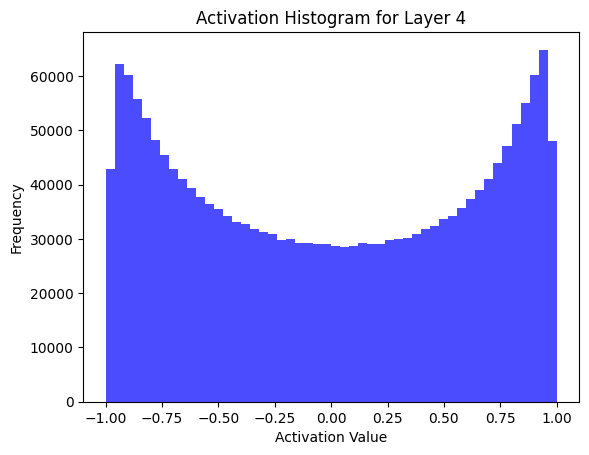

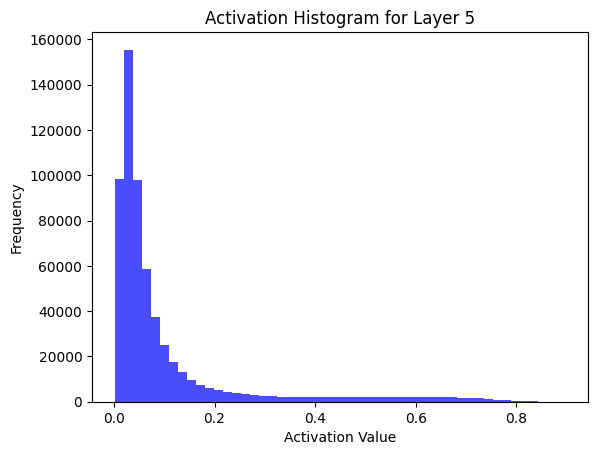

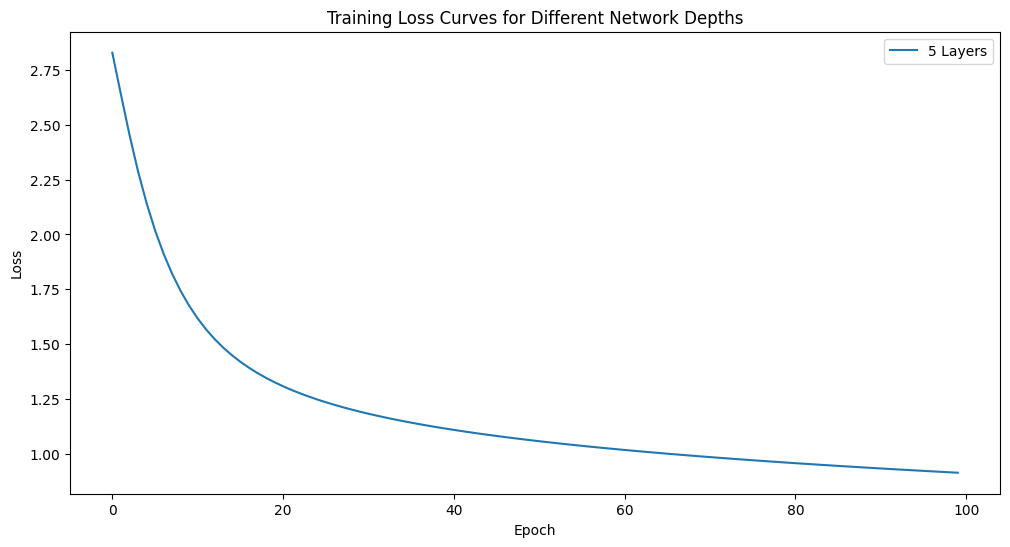

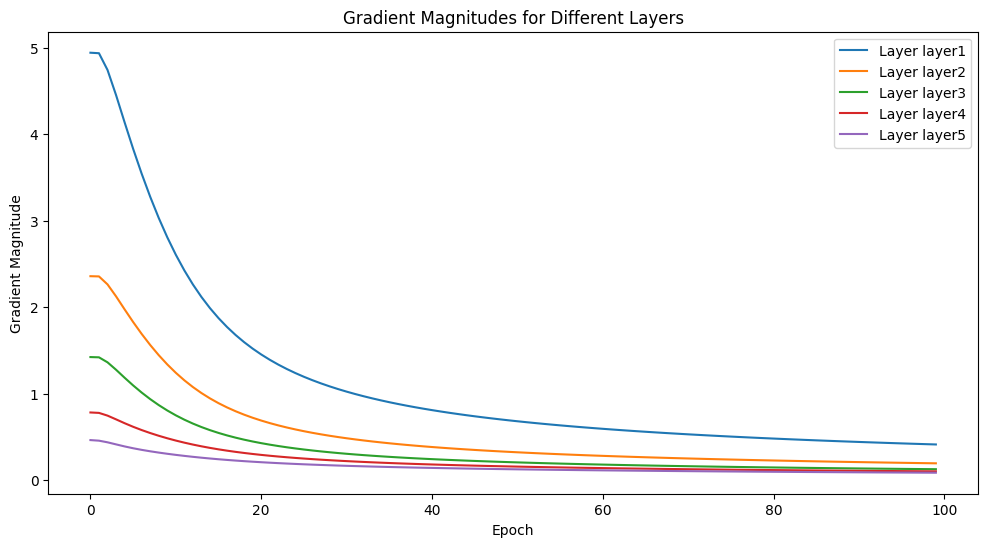

In [16]:
# Define network configurations for 3, 5, 7, and 10 layers
network_configs = [
    # 6layer network
    ([784, 256, 128, 64, 32, 10], ["tanh", "tanh", "tanh", "tanh", "softmax"]),
]

# Train and evaluate each network configuration
loss_histories = []
accuracies = []
gradient_magnitudes_histories = []

for layer_sizes, activations in network_configs:
    print(f"Training Tanh network with {len(layer_sizes) - 1} layers using He initialization")
    loss_history, accuracy, gradient_magnitudes_history = train_and_evaluate_network(X_train, y_train, X_test, y_test, layer_sizes, activations, num_epochs=100, learning_rate=0.01, initialization="he")
    loss_histories.append(loss_history)
    accuracies.append(accuracy)
    gradient_magnitudes_histories.append(gradient_magnitudes_history)

# Plot training loss curves for networks of different depths
plt.figure(figsize=(12, 6))
for i, loss_history in enumerate(loss_histories):
    plt.plot(loss_history, label=f'{len(network_configs[i][0]) - 1} Layers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves for Different Network Depths')
plt.legend()
plt.show()


# Plot gradient magnitudes for different layers
plot_gradient_magnitudes(gradient_magnitudes_histories[0])

